In [ ]:
!pip install optuna
!pip install torch

# Model Architecture

In [ ]:
import torch
import torch.nn as nn

# 4. Define the N‑Beats Model Architecture
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_size, nb_layers):
        super().__init__()
        layers = []
        in_features = input_size
        for _ in range(nb_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        self.fc = nn.Sequential(*layers)
        self.theta_layer = nn.Linear(hidden_size, theta_size)

    def forward(self, x):
        x = self.fc(x)
        theta = self.theta_layer(x)
        return theta

class NBeats(nn.Module):
    def __init__(self, input_size, forecast_size, hidden_size=64, nb_layers=4, nb_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, forecast_size, hidden_size, nb_layers)
            for _ in range(nb_blocks)
        ])

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            forecast += block(x)
        return forecast


# Data Preparation

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def prepare_data(file_path):
    df = pd.read_csv(file_path)
    df  =df.reset_index()
    df = df.rename(columns={"Date": "ds",
                            "Close": "y",
                            "High": "High",
                            "Low": "Low",
                            "Open": "Open"})
    df = df.drop(columns=['Volume'], axis=1)
    df['ds'] = pd.to_datetime(df['ds'])

    return df

def split_data(df):
    latest_date = pd.Timestamp(df['ds'].max())
    last_year_data = latest_date.year -2

    test= df[(df['ds'].dt.year >= last_year_data)]
    test_start = pd.Timestamp(test['ds'].min())

    val_start = test_start - pd.DateOffset(years=3)
    val_end = test_start - pd.DateOffset(days=1)
    val = df[(df['ds'] >= val_start) & (df['ds'] <= val_end)]

    train_end = val_start - pd.DateOffset(days=1)
    train = df[(df['ds'] <= train_end)]
    return test,val,train


def create_sequences(data, input_window, forecast_window):
    X, y = [], []
    step = 7  # Slide the window by 7 days

    for i in range(0,len(data) - input_window - forecast_window,step):
        X.append(data[i:i+input_window])
        y.append(data[i+input_window:i+input_window+forecast_window])
    return np.array(X), np.array(y)

In [ ]:
df = prepare_data("tsla-2010-2024.csv")
df.drop('index', axis= True, inplace = True)

In [ ]:
df

,ds,Open,High,Low,y
0,2010-06-29,1.27,1.67,1.17,1.59
1,2010-06-30,1.72,2.03,1.55,1.59
2,2010-07-01,1.67,1.73,1.35,1.46
3,2010-07-02,1.53,1.54,1.25,1.28
4,2010-07-06,1.33,1.33,1.06,1.07
...,...,...,...,...,...
3647,2024-12-24,435.90,462.78,435.14,462.28
3648,2024-12-26,465.16,465.33,451.02,454.13
3649,2024-12-27,449.52,450.00,426.50,431.66
3650,2024-12-30,419.40,427.00,415.75,417.41


In [ ]:
test,val,train = split_data(df)

In [ ]:
test,val,train = split_data(df)

In [ ]:
train.ds.iloc[0],train.ds.iloc[-1]

(Timestamp('2010-06-29 00:00:00'), Timestamp('2019-01-02 00:00:00'))

In [ ]:
val.ds.iloc[0],val.ds.iloc[-1]

(Timestamp('2019-01-03 00:00:00'), Timestamp('2021-12-31 00:00:00'))

In [ ]:
test.ds.iloc[0],test.ds.iloc[-1]

(Timestamp('2022-01-03 00:00:00'), Timestamp('2024-12-31 00:00:00'))

# Tuning the Model

In [ ]:
def compute_directions(test_results):

    test_results = test_results.dropna(subset=['y', 'yhat'])
    predicted_dir = (test_results['yhat'] >test_results['last_actual']).astype(int)
    actual_dir = (test_results['y'] > test_results['last_actual']).astype(int)

    test_results ['predicted_dir'] =predicted_dir
    test_results ['actual_dir'] =actual_dir

    return test_results

In [ ]:
def calculate_success_rate(test_results, WINDOW_SIZE):
    # Constants
    POINTS = np.array([500, 1000, 1500])  # Using numpy array for vectorized operations
    # Initialize success counts
    success = np.zeros_like(POINTS, dtype=int)  # [0, 0, 0]
    logs = pd.DataFrame(columns=['seq','Target','Value','Last Actual','direction','Hits'])

    for i in range(0, len(test_results), WINDOW_SIZE):
        window = test_results.iloc[i:i + WINDOW_SIZE]
        predicted_dir = window['predicted_dir'].mode().iloc[0]  # Get predicted direction for the window
        last_actual = window['last_actual'].iloc[0]  # Get the last actual value for the window

        for j in range(len(POINTS)):  # Iterate through each target
            if predicted_dir == 0:  # Bearish case
                target = last_actual - POINTS[j] * 0.01
                hits = (window['Low'].values <= target.item()).any()  # Check if any Low is <= target
            else:  # Bullish case
                target = last_actual + POINTS[j] * 0.01
                hits = (window['High'].values >= target.item()).any()  # Check if any High is >= target
            if hits:
                success[j] += 1  # Increment success count if condition met


            log = { 'seq': i/WINDOW_SIZE,
                    'Target': j+1,
                    'Value': target,
                   'Last Actual':last_actual,
                   'direction':predicted_dir,
                   'Hits':hits}
            logs.loc[len(logs)] = log

    # Calculate success rate
    total_windows = len(test_results) // WINDOW_SIZE
    success_rate = success / total_windows

    print(f"Success counts: {success}, Total window {total_windows}")  # Debugging print statement
    print(f"Success rates: {success_rate}")  # Debugging print statement

    return success_rate,logs


In [ ]:
def tuning_model(train, val):
    def objective(trial, train, val):
        import torch
        import torch.nn as nn
        import torch.optim as optim
        import numpy as np
        import pandas as pd

        month = 22
        week = 5
        # Hyperparameter search space
        input_window = trial.suggest_categorical("input_window", [3 * month, 4 * month, 6 * month, 9 * month, 12 * month])
        forecast_window = trial.suggest_categorical("forecast_window", [2 * week, month])
        hidden_size = trial.suggest_int("hidden_size", 64, 256)
        nb_layers = trial.suggest_int("nb_layers", 2, 8)
        nb_blocks = trial.suggest_int("nb_blocks", 1, 8)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

        # Device setup
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        model = NBeats(
            input_size=input_window,
            forecast_size=forecast_window,
            hidden_size=hidden_size,
            nb_layers=nb_layers,
            nb_blocks=nb_blocks
        ).to(device)

        # Loss and optimizer
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        X_train, y_train = create_sequences(train['y'].values, input_window, forecast_window)
        X_val, y_val = create_sequences(val['y'].values, input_window, forecast_window)
        X_ds, y_ds = create_sequences(val['ds'].values, input_window, forecast_window)

        # Convert to tensors
        X_train = torch.FloatTensor(X_train).to(device)
        y_train = torch.FloatTensor(y_train).to(device)
        X_val = torch.FloatTensor(X_val).to(device)
        y_val = torch.FloatTensor(y_val).to(device)

        # Training loop
        model.train()
        for epoch in range(3):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = loss_fn(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)

        if val_pred.shape != y_val.shape:
            raise ValueError(f"Shape mismatch: pred {val_pred.shape} vs true {y_val.shape}")

        final_results = pd.DataFrame()
        val = val.copy()

        for i in range(len(val_pred)):
            forecast = pd.DataFrame({'yhat': val_pred[i].cpu().numpy(), 'ds': y_ds[i]})
            forecast['ds'] = pd.to_datetime(forecast['ds']).dt.tz_localize(None)
            val['ds'] = pd.to_datetime(val['ds']).dt.tz_localize(None)

            val_results = pd.merge(val, forecast, on='ds', how='inner')
            val_results['last_actual'] = X_train[i][-1].item()
            results = compute_directions(val_results)
            final_results = pd.concat([final_results, results], ignore_index=True)

        success_rate,log = calculate_success_rate(final_results, forecast_window)
        return success_rate[0].item()

    import optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train, val), n_trials=50)

    best_params = study.best_trial.params
    best_lr = best_params["learning_rate"]

    print("Best trial:")
    print(best_params)

    return best_params, best_lr


In [ ]:
best_params, lr = tuning_model(train, val)
print("Best LR:", lr)


[I 2025-05-07 04:48:09,490] A new study created in memory with name: no-name-77a91ac7-bd1f-41d9-b265-f9c1b3df9f4e
[I 2025-05-07 04:48:10,602] Trial 0 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 215, 'nb_layers': 6, 'nb_blocks': 4, 'learning_rate': 0.005479403867790204}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:11,493] Trial 1 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 123, 'nb_layers': 3, 'nb_blocks': 1, 'learning_rate': 0.0015823235316896628}. Best is trial 0 with value: 1.0.


Success counts: [94 94 85], Total window 94
Success rates: [1.         1.         0.90425532]


[I 2025-05-07 04:48:12,440] Trial 2 finished with value: 0.9148936170212766 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 179, 'nb_layers': 2, 'nb_blocks': 5, 'learning_rate': 0.009080060551487917}. Best is trial 0 with value: 1.0.


Success counts: [86 86 81], Total window 94
Success rates: [0.91489362 0.91489362 0.86170213]


[I 2025-05-07 04:48:13,298] Trial 3 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 166, 'nb_layers': 5, 'nb_blocks': 6, 'learning_rate': 0.00047708881548911056}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:14,123] Trial 4 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 203, 'nb_layers': 2, 'nb_blocks': 8, 'learning_rate': 0.0005234703187119582}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:14,974] Trial 5 finished with value: 0.6086956521739131 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 124, 'nb_layers': 5, 'nb_blocks': 2, 'learning_rate': 0.0006964184830410038}. Best is trial 0 with value: 1.0.


Success counts: [42 42 42], Total window 69
Success rates: [0.60869565 0.60869565 0.60869565]


[I 2025-05-07 04:48:16,124] Trial 6 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 168, 'nb_layers': 3, 'nb_blocks': 1, 'learning_rate': 0.006343599479898399}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:16,992] Trial 7 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 220, 'nb_layers': 2, 'nb_blocks': 5, 'learning_rate': 0.00010760737722867777}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:18,063] Trial 8 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 217, 'nb_layers': 2, 'nb_blocks': 6, 'learning_rate': 0.003271672537521905}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:18,974] Trial 9 finished with value: 1.0 and parameters: {'input_window': 198, 'forecast_window': 22, 'hidden_size': 164, 'nb_layers': 8, 'nb_blocks': 3, 'learning_rate': 0.006879023545734249}. Best is trial 0 with value: 1.0.


Success counts: [77 77 77], Total window 77
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:20,069] Trial 10 finished with value: 1.0 and parameters: {'input_window': 132, 'forecast_window': 22, 'hidden_size': 251, 'nb_layers': 8, 'nb_blocks': 3, 'learning_rate': 0.002074897816871484}. Best is trial 0 with value: 1.0.


Success counts: [86 86 85], Total window 86
Success rates: [1.         1.         0.98837209]


[I 2025-05-07 04:48:21,177] Trial 11 finished with value: 0.5483870967741935 and parameters: {'input_window': 88, 'forecast_window': 22, 'hidden_size': 74, 'nb_layers': 6, 'nb_blocks': 1, 'learning_rate': 0.0021444293319125554}. Best is trial 0 with value: 1.0.


Success counts: [51 51 51], Total window 93
Success rates: [0.5483871 0.5483871 0.5483871]


[I 2025-05-07 04:48:22,197] Trial 12 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 120, 'nb_layers': 4, 'nb_blocks': 3, 'learning_rate': 0.001359952685366576}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:23,322] Trial 13 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 124, 'nb_layers': 6, 'nb_blocks': 8, 'learning_rate': 0.004061390415272359}. Best is trial 0 with value: 1.0.


Success counts: [94 94 85], Total window 94
Success rates: [1.         1.         0.90425532]


[I 2025-05-07 04:48:24,232] Trial 14 finished with value: 0.0 and parameters: {'input_window': 132, 'forecast_window': 22, 'hidden_size': 95, 'nb_layers': 7, 'nb_blocks': 2, 'learning_rate': 0.00024901762987773057}. Best is trial 0 with value: 1.0.


Success counts: [0 0 0], Total window 86
Success rates: [0. 0. 0.]


[I 2025-05-07 04:48:25,150] Trial 15 finished with value: 1.0 and parameters: {'input_window': 198, 'forecast_window': 10, 'hidden_size': 253, 'nb_layers': 4, 'nb_blocks': 4, 'learning_rate': 0.001021427551536733}. Best is trial 0 with value: 1.0.


Success counts: [79 79 79], Total window 79
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:26,239] Trial 16 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 142, 'nb_layers': 4, 'nb_blocks': 7, 'learning_rate': 0.0031737212004907677}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:27,270] Trial 17 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 196, 'nb_layers': 6, 'nb_blocks': 4, 'learning_rate': 0.0016702682588138717}. Best is trial 0 with value: 1.0.


Success counts: [94 94 85], Total window 94
Success rates: [1.         1.         0.90425532]


[I 2025-05-07 04:48:28,180] Trial 18 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 22, 'hidden_size': 87, 'nb_layers': 3, 'nb_blocks': 2, 'learning_rate': 0.0037607427180811745}. Best is trial 0 with value: 1.0.


Success counts: [93 93 87], Total window 93
Success rates: [1.         1.         0.93548387]


[I 2025-05-07 04:48:29,189] Trial 19 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 143, 'nb_layers': 7, 'nb_blocks': 1, 'learning_rate': 0.005856652731243436}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:30,241] Trial 20 finished with value: 0.38636363636363635 and parameters: {'input_window': 132, 'forecast_window': 10, 'hidden_size': 189, 'nb_layers': 3, 'nb_blocks': 6, 'learning_rate': 0.009876896980411822}. Best is trial 0 with value: 1.0.


Success counts: [34 34 34], Total window 88
Success rates: [0.38636364 0.38636364 0.38636364]


[I 2025-05-07 04:48:31,321] Trial 21 finished with value: 0.7246376811594203 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 144, 'nb_layers': 5, 'nb_blocks': 6, 'learning_rate': 0.000351588648923688}. Best is trial 0 with value: 1.0.


Success counts: [50 50 50], Total window 69
Success rates: [0.72463768 0.72463768 0.72463768]


[I 2025-05-07 04:48:32,493] Trial 22 finished with value: 0.9420289855072463 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 230, 'nb_layers': 5, 'nb_blocks': 7, 'learning_rate': 0.00020532328544467992}. Best is trial 0 with value: 1.0.


Success counts: [65 65 65], Total window 69
Success rates: [0.94202899 0.94202899 0.94202899]


[I 2025-05-07 04:48:33,496] Trial 23 finished with value: 0.0 and parameters: {'input_window': 198, 'forecast_window': 10, 'hidden_size': 104, 'nb_layers': 7, 'nb_blocks': 5, 'learning_rate': 0.0006886845161373838}. Best is trial 0 with value: 1.0.


Success counts: [0 0 0], Total window 79
Success rates: [0. 0. 0.]


[I 2025-05-07 04:48:34,648] Trial 24 finished with value: 0.723404255319149 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 150, 'nb_layers': 5, 'nb_blocks': 7, 'learning_rate': 0.0004131613978523109}. Best is trial 0 with value: 1.0.


Success counts: [68 68 67], Total window 94
Success rates: [0.72340426 0.72340426 0.71276596]


[I 2025-05-07 04:48:35,550] Trial 25 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 177, 'nb_layers': 6, 'nb_blocks': 4, 'learning_rate': 0.0009858846250018294}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:36,871] Trial 26 finished with value: 0.0 and parameters: {'input_window': 66, 'forecast_window': 22, 'hidden_size': 65, 'nb_layers': 4, 'nb_blocks': 6, 'learning_rate': 0.00014249684537246345}. Best is trial 0 with value: 1.0.


Success counts: [0 0 0], Total window 96
Success rates: [0. 0. 0.]


[I 2025-05-07 04:48:38,078] Trial 27 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 237, 'nb_layers': 3, 'nb_blocks': 5, 'learning_rate': 0.0011989414051695511}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:39,655] Trial 28 finished with value: 0.5306122448979592 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 204, 'nb_layers': 7, 'nb_blocks': 3, 'learning_rate': 0.0007127833659194348}. Best is trial 0 with value: 1.0.


Success counts: [52 52 52], Total window 98
Success rates: [0.53061224 0.53061224 0.53061224]


[I 2025-05-07 04:48:40,811] Trial 29 finished with value: 0.22340425531914893 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 112, 'nb_layers': 6, 'nb_blocks': 5, 'learning_rate': 0.0003776336667825358}. Best is trial 0 with value: 1.0.


Success counts: [21 21 21], Total window 94
Success rates: [0.22340426 0.22340426 0.22340426]


[I 2025-05-07 04:48:41,855] Trial 30 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 186, 'nb_layers': 4, 'nb_blocks': 2, 'learning_rate': 0.0022432576441695187}. Best is trial 0 with value: 1.0.


Success counts: [94 94 85], Total window 94
Success rates: [1.         1.         0.90425532]


[I 2025-05-07 04:48:42,717] Trial 31 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 205, 'nb_layers': 2, 'nb_blocks': 8, 'learning_rate': 0.0006280904201056024}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:43,616] Trial 32 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 175, 'nb_layers': 2, 'nb_blocks': 8, 'learning_rate': 0.0005350027526640081}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:44,542] Trial 33 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 217, 'nb_layers': 3, 'nb_blocks': 7, 'learning_rate': 0.00028084490738361316}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:45,348] Trial 34 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 128, 'nb_layers': 2, 'nb_blocks': 8, 'learning_rate': 0.00047655423108316526}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:46,357] Trial 35 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 164, 'nb_layers': 5, 'nb_blocks': 6, 'learning_rate': 0.0008639610586304514}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:47,651] Trial 36 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 207, 'nb_layers': 2, 'nb_blocks': 7, 'learning_rate': 0.00017598350224698096}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:48,611] Trial 37 finished with value: 1.0 and parameters: {'input_window': 198, 'forecast_window': 10, 'hidden_size': 154, 'nb_layers': 3, 'nb_blocks': 4, 'learning_rate': 0.0052412651835882776}. Best is trial 0 with value: 1.0.


Success counts: [79 79 79], Total window 79
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:49,667] Trial 38 finished with value: 1.0 and parameters: {'input_window': 132, 'forecast_window': 22, 'hidden_size': 235, 'nb_layers': 2, 'nb_blocks': 1, 'learning_rate': 0.007672795452789301}. Best is trial 0 with value: 1.0.


Success counts: [86 86 85], Total window 86
Success rates: [1.         1.         0.98837209]


[I 2025-05-07 04:48:50,461] Trial 39 finished with value: 1.0 and parameters: {'input_window': 264, 'forecast_window': 10, 'hidden_size': 133, 'nb_layers': 3, 'nb_blocks': 5, 'learning_rate': 0.0015914352929462133}. Best is trial 0 with value: 1.0.


Success counts: [69 69 69], Total window 69
Success rates: [1. 1. 1.]


[I 2025-05-07 04:48:51,543] Trial 40 finished with value: 0.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 222, 'nb_layers': 8, 'nb_blocks': 3, 'learning_rate': 0.00030350033101756053}. Best is trial 0 with value: 1.0.


Success counts: [0 0 0], Total window 98
Success rates: [0. 0. 0.]


[I 2025-05-07 04:48:52,478] Trial 41 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 171, 'nb_layers': 3, 'nb_blocks': 1, 'learning_rate': 0.007565566593620211}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:53,445] Trial 42 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 181, 'nb_layers': 4, 'nb_blocks': 1, 'learning_rate': 0.002630030434048687}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:54,520] Trial 43 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 22, 'hidden_size': 162, 'nb_layers': 2, 'nb_blocks': 2, 'learning_rate': 0.00588442805794561}. Best is trial 0 with value: 1.0.


Success counts: [96 96 90], Total window 96
Success rates: [1.     1.     0.9375]


[I 2025-05-07 04:48:55,475] Trial 44 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 192, 'nb_layers': 6, 'nb_blocks': 3, 'learning_rate': 0.004025935021629196}. Best is trial 0 with value: 1.0.


Success counts: [94 94 85], Total window 94
Success rates: [1.         1.         0.90425532]


[I 2025-05-07 04:48:56,507] Trial 45 finished with value: 1.0 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 245, 'nb_layers': 5, 'nb_blocks': 2, 'learning_rate': 0.004746062744543316}. Best is trial 0 with value: 1.0.


Success counts: [98 98 87], Total window 98
Success rates: [1.        1.        0.8877551]


[I 2025-05-07 04:48:57,366] Trial 46 finished with value: 1.0 and parameters: {'input_window': 132, 'forecast_window': 10, 'hidden_size': 168, 'nb_layers': 3, 'nb_blocks': 1, 'learning_rate': 0.002771883572063331}. Best is trial 0 with value: 1.0.


Success counts: [88 88 85], Total window 88
Success rates: [1.         1.         0.96590909]


[I 2025-05-07 04:48:58,237] Trial 47 finished with value: 0.948051948051948 and parameters: {'input_window': 198, 'forecast_window': 22, 'hidden_size': 199, 'nb_layers': 4, 'nb_blocks': 3, 'learning_rate': 0.0005386462541347609}. Best is trial 0 with value: 1.0.


Success counts: [73 73 73], Total window 77
Success rates: [0.94805195 0.94805195 0.94805195]


[I 2025-05-07 04:48:59,202] Trial 48 finished with value: 1.0 and parameters: {'input_window': 88, 'forecast_window': 10, 'hidden_size': 215, 'nb_layers': 2, 'nb_blocks': 2, 'learning_rate': 0.008438415214532084}. Best is trial 0 with value: 1.0.


Success counts: [94 94 85], Total window 94
Success rates: [1.         1.         0.90425532]


[I 2025-05-07 04:49:00,425] Trial 49 finished with value: 0.5408163265306123 and parameters: {'input_window': 66, 'forecast_window': 10, 'hidden_size': 156, 'nb_layers': 7, 'nb_blocks': 6, 'learning_rate': 0.0008156068115035487}. Best is trial 0 with value: 1.0.


Success counts: [53 53 53], Total window 98
Success rates: [0.54081633 0.54081633 0.54081633]
Best trial:
{'input_window': 66, 'forecast_window': 10, 'hidden_size': 215, 'nb_layers': 6, 'nb_blocks': 4, 'learning_rate': 0.005479403867790204}
Best LR: 0.005479403867790204


# Train Best Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

def train_best_model(train_series, val_series, params, device=None, n_epochs=100, patience=10):

    # Unpack parameters
    input_window = params['input_window']
    hidden_size = params['hidden_size']
    nb_blocks = params['nb_blocks']
    nb_layers = params['nb_layers']
    lr = params['learning_rate']
    forecast_window = params['forecast_window']  # Match your objective function

    # Device setup
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train, y_train = create_sequences(train_series['y'].values, input_window, forecast_window)
    X_val, y_val = create_sequences(val_series['y'].values, input_window, forecast_window)

    # Convert to tensors
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val)
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model
    model = NBeats(
        input_size=input_window,
        forecast_size=forecast_window,
        hidden_size=hidden_size,
        nb_layers=nb_layers,
        nb_blocks=nb_blocks
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        #print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history


In [ ]:
# Train with best parameters
trained_model, history = train_best_model(
    train,
    val,
    best_params,
    n_epochs=50,
    patience=15)

# Evaluate the model

In [ ]:
def make_forecast(trained_model, test ,input_window, forecast_window):

    X_test, y_test = create_sequences(test['y'].values, input_window, forecast_window)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    X_ds,y_ds=create_sequences(test['ds'].values, input_window, forecast_window)

    # Move to correct device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t = X_test_t.to(device)
    last_actual= X_test[:, -1]
    with torch.no_grad():
        preds = trained_model(X_test_t).cpu().numpy()

    return preds,y_ds,last_actual

In [ ]:
preds,y_ds,last_actual = make_forecast(trained_model,test,best_params['input_window'],best_params['forecast_window'])

In [ ]:
def create_test_results(preds, pred_ds, last_actual, test, forecast_window):
    final_results = pd.DataFrame()
    test = test.copy()
    for i in range(len(preds)):
        forecast = pd.DataFrame({'yhat' : preds[i], 'ds':y_ds[i]})
        forecast['ds'] = forecast['ds'].dt.tz_localize(None)
        test['ds'] = test['ds'].dt.tz_localize(None)

        test_results = pd.merge(test,forecast,on = 'ds' , how = 'inner')
        test_results['last_actual'] = last_actual[i]

        results = compute_directions(test_results)
        final_results = pd.concat([final_results, results], ignore_index=True)
    return final_results

In [ ]:
tr = create_test_results(preds, y_ds, last_actual, test, best_params['forecast_window'])

In [ ]:
tr

,ds,Open,High,Low,y,yhat,last_actual,predicted_dir,actual_dir
0,2022-04-07,350.80,358.86,340.51,352.42,332.479706,348.59,0,1
1,2022-04-08,347.74,349.48,340.81,341.83,336.764832,348.59,0,0
2,2022-04-11,326.80,336.16,324.88,325.31,331.916321,348.59,0,0
3,2022-04-12,332.55,340.40,325.53,328.98,334.810760,348.59,0,0
4,2022-04-13,327.02,342.08,324.37,340.79,336.272552,348.59,0,0
...,...,...,...,...,...,...,...,...,...
965,2024-12-17,475.90,483.99,457.51,479.86,338.019714,389.79,0,1
966,2024-12-18,466.50,488.54,427.01,440.13,338.069366,389.79,0,1
967,2024-12-19,451.88,456.36,420.02,436.17,337.173981,389.79,0,1
968,2024-12-20,425.51,447.08,417.64,421.06,340.296570,389.79,0,1


In [ ]:
import matplotlib.pyplot as plt

def plot_results(test_results, last_actual):
    predicted_dir = test_results['predicted_dir'].mode().iloc[0]  # Get predicted direction for the window

    plt.figure(figsize=(12, 6))

    if predicted_dir == 0:
        # Plot actual and predicted values
        plt.plot(test_results['ds'], test_results['Low'], label="Actual (Test)", color='green', alpha=0.6)
    else:
        plt.plot(test_results['ds'], test_results['High'], label="Actual (Test)", color='green', alpha=0.6)

    plt.plot(test_results['ds'], test_results['yhat'], label="Predicted (Test)", color='red', linestyle='--')

    open = test_results['Open'].iloc[0]

    # Add horizontal line for last actual
    plt.axhline(y=last_actual, color='black', linestyle=':', linewidth=1.5, label=f'Last Actual: {last_actual:.2f}')
    plt.axhline(y=open, color='blue', linestyle=':', linewidth=1.5, label=f'Open: {open:.2f}')


    plt.title("BTC Price: Actual vs. Predicted (BTC Data with Prediction Interval)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


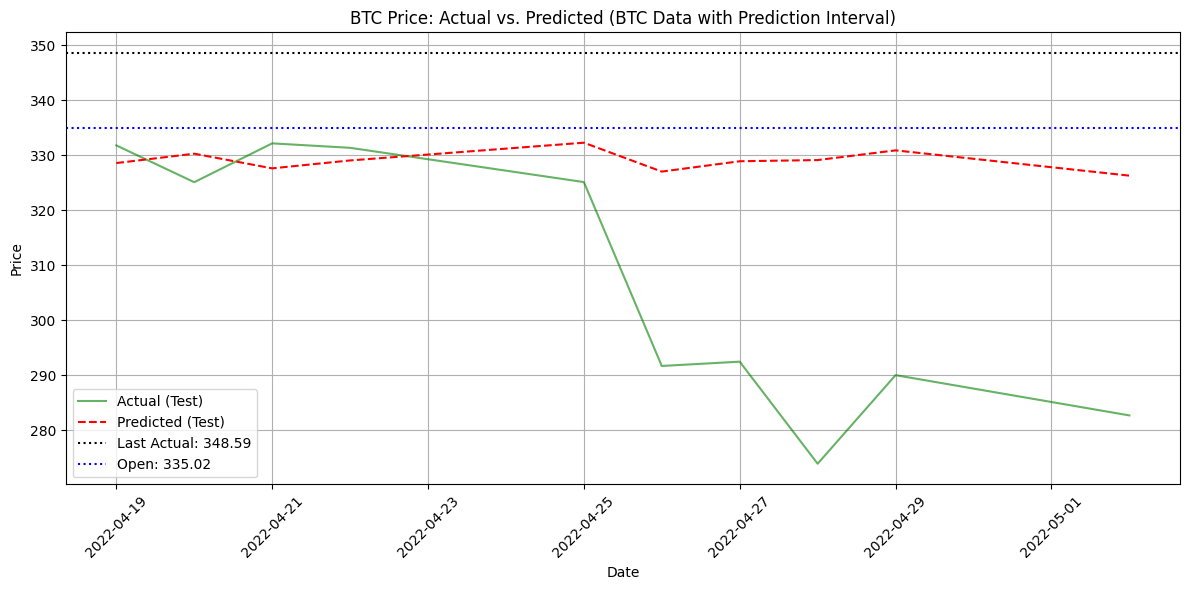

In [ ]:
plot_results(tr.iloc[0+10:10+10], tr['last_actual'].iloc[0])

In [ ]:
success_rate,log = calculate_success_rate(tr,14)

Success counts: [42 38 29], Total window 69
Success rates: [0.60869565 0.55072464 0.42028986]


In [ ]:
print(f"1st target= {success_rate[0]}")
print(f"2nd target= {success_rate[1]}")
print(f"3rd target= {success_rate[2]}")


1st target= 0.6086956521739131
2nd target= 0.5507246376811594
3rd target= 0.42028985507246375


In [ ]:
log

,seq,Target,Value,Last Actual,direction,Hits
0,0.0,1,343.59,348.59,0,True
1,0.0,2,338.59,348.59,0,True
2,0.0,3,333.59,348.59,0,True
3,1.0,1,339.76,334.76,1,False
4,1.0,2,344.76,334.76,1,False
...,...,...,...,...,...,...
205,68.0,2,322.89,332.89,0,False
206,68.0,3,317.89,332.89,0,False
207,69.0,1,384.79,389.79,0,False
208,69.0,2,379.79,389.79,0,False
